# Code for sctype class 
### (10-15-2020)
- initializing the sctype class imports 10Xv2 data with genes.tsv, barcodes.tsv, and matrix.mtx files
- must provide path to the directory with these three files.
- Need to import cell type annotations manually with pd.read_csv()

### (10-19-2020)
- SVM implemented with LinearSVC 
    - SVC was giving me "AttributeError: var not found"
    - Not sure how to resolve this error, but documentation recommends LinearSVC for large datasets anyways
- changed the output of train_test_split() to split all train/test data as well as labels (4 outputs)

### (10-20-2020)
- Added CalibratedClassifierCV() wrapper to model to calibrate probabilities
- Use predict_proba() method to get probabilities for each class

In [1]:
import numpy as np
import pandas as pd
import scipy.io as io
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


# path = path to the 10Xv2 data directory containing genes.tsv, barcodes.tsv, and matrix.mtx files
# Note: need to import cell type annotations file manually since annotation files do not 
# have any set format between datasets. Set index names to cell barcode IDs in the annotation dataframe
# and have the celltype annotations as the first column.


class sctype:
    def __init__(self, path):
        self.genes = pd.read_csv(path + 'genes.tsv', sep = '\t', header = None).iloc[:,1]
        self.barcodes = pd.read_csv(path + 'barcodes.tsv', sep = '\t', header = None).iloc[:,0]
        expression = io.mmread(path + 'matrix.mtx') 
        
        data = pd.DataFrame.sparse.from_spmatrix(data = expression, index = self.genes, columns = self.barcodes)
        data = data.fillna(0)
        gene_counts = data.sum(axis = 1)
        data = data[gene_counts != 0]
        
        self.data = data.transpose()
        self.dropouts = gene_counts[gene_counts == 0].index
    
    
# This preprocess step will divide the gene counts by the total counts per cell, multiply by scale_factor
# and perform log1p; output is normalized logCPM data. 
# Scale will center the per gene expression data around 0 and adjust to unit variance.
# Though, this doesn't seem to affect NN performance too much. Can feed self.data to the split method
# and go directly to training the NN without running this preprocessing step.

    def data_preprocess(self, normalize = True, scale_factor = 10000, scale = True):
        if normalize:
            cell_counts = self.data.sum(axis = 1)
            div = self.data.divide(other = cell_counts, axis = 'index')
            self.data_norm = np.log1p(div * scale_factor)
        if scale:
            if normalize:
                self.data_norm = (self.data_norm - np.mean(self.data_norm, axis = 0))\
                /(np.std(self.data_norm, axis = 0))
            else:
                self.data_scaled = (self.data - np.mean(self.data, axis = 0))\
                /(np.std(self.data, axis = 0))

                
# Labels input should be a dataframe with cell barcode IDs as indices and celltype annotations 
# in the first column. This will convert labels with one-hot encoding for use as labels in the NN
# must be done BEFORE splitting into train/test sets.

# The key to the one-hot encoded labels will be stored in self.key
# The original labels will be stored in self.labels

    def process_labels(self, labels):
        labels[labels == ['CD4+/CD45RO+ Memory']] = 'CD4+ T' 
        labels[labels == ['CD4+/CD25 T Reg']] = 'CD4+ T' 
        labels[labels == ['CD4+ T Helper2']] = 'CD4+ T' 
        labels[labels == ['CD4+/CD45RA+/CD25- Naive T']] = 'CD4+ T' 
        labels[labels == ['CD8+ Cytotoxic T']] = 'CD8+ T'
        labels[labels == ['CD8+/CD45RA+ Naive Cytotoxic']] = 'CD8+ T'
        self.labels = labels
    
    def split(self, data, labels, test_size, random_state):
        self.train_data, self.test_data, self.train_labels, self.test_labels = train_test_split(
            data, labels, test_size=test_size,
            random_state=random_state, stratify=labels)

    def svm(self, iterations = 1000, cv = 4, method = 'sigmoid'):
#     def svm(self, iterations = 1000):
        clf = LinearSVC(max_iter = iterations)
        clf = CalibratedClassifierCV(clf, cv = cv, method = method)
        self.svmfit = clf.fit(self.train_data, self.train_labels.iloc[:,0])
        return self.svmfit

Define paths for Zheng 68k PBMC dataset/annotations, and import annotations:

In [2]:
path_data = '/Users/leealj/py_projects/biof509_final/zheng68k/filtered_matrices_mex/hg19/'
path_anno = '/Users/leealj/py_projects/biof509_final/zheng68k/'
labels = pd.read_csv(path_anno + '68k_pbmc_barcodes_annotation.tsv', sep = '\t').loc[:,["barcodes","celltype"]]
labels.set_index("barcodes", inplace = True)

Create the sctype class and check data

In [3]:
zheng = sctype(path_data)

In [ ]:
# zheng.data_preprocess(normalize = True, scale = True)

In [4]:
zheng.process_labels(labels)

In [5]:
zheng.split(data = zheng.data, labels = zheng.labels, test_size = 0.25, random_state = 40)

In [6]:
model = zheng.svm()

/Users/leealj/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/leealj/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/leealj/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/leealj/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [7]:
predictions_train = model.predict(zheng.train_data)
predictions_test = model.predict(zheng.test_data)

In [8]:
print("The prediction accuracy on the train set is: {}"\
      .format(sum(predictions_train == zheng.train_labels.iloc[:,0])/len(predictions_train)))
print("The prediction accuracy on the test set is: {}"\
      .format(sum(predictions_test == zheng.test_labels.iloc[:,0])/len(predictions_test)))

The prediction accuracy on the train set is: 0.926080024886262
The prediction accuracy on the test set is: 0.8323709536307962


In [ ]:
# Use cross validation
# cv_scores = []
# for model, params in cv_svms:
#     cv_scores.append(cv_demo.cross_val(model, cv_demo.data, 5))

In [14]:
# test_probs = model.decision_function(zheng.test_data)
# test_probs = (test_probs-test_probs.min())/(test_probs.max()-test_probs.min())

test_probs = model.predict_proba(zheng.test_data)

print(test_probs.min())
print(test_probs.max())

7.107265201814256e-42
0.9999999735416614


## Generating heatmaps and violin plots


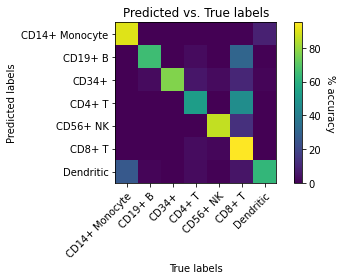

In [10]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

confmatrix = confusion_matrix(zheng.test_labels.iloc[:,0], predictions_test, normalize = 'true')
celltypes = np.unique(zheng.test_labels.iloc[:,0])

fig, ax = plt.subplots()
im = ax.imshow(confmatrix*100)

ax.set_xticks(np.arange(len(celltypes)))
ax.set_yticks(np.arange(len(celltypes)))

ax.set_xticklabels(celltypes)
ax.set_yticklabels(celltypes)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("% accuracy", rotation=-90, va="bottom")

ax.set_ylabel("Predicted labels")
ax.set_xlabel("True labels")
ax.set_title("Predicted vs. True labels")
fig.tight_layout()
# plt.savefig(fname = '/Users/leealj/py_projects/biof509_final/svm_heatmap.png', dpi = 500, transparent = True)
plt.show()